# 캐글 따라해보기! 프로젝트

### 사용할 모듈 패키지 불러오기!

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

### 데이터 가져오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### 데이터 전처리

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


데이터를 확인해보니 date에 20141013T000000 같은 형식으로 날짜 뒷쪽에 T000000 같은 쓸모 없는 부분이 있다.   
바로 제거!!

In [4]:
train['date'] = train['date'].apply(lambda i: i[:8]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


테스트 데이터도 훈련 데이터와 마찬가지로 date 컬럼에 날짜 뒤쪽의 필요 없는 내용을 지워준다.

In [6]:
test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


가격 데이터의 분포를 확인해보자!

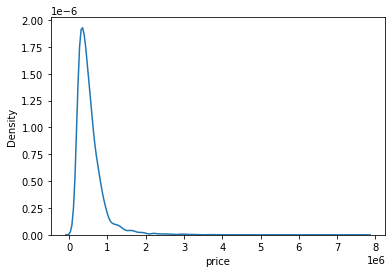

In [7]:
sns.kdeplot(train['price'])
plt.show()

가격 데이터의 분포가 한쪽에 치우쳐져 있는 것을 확인했다.   
log 변환을 해줘서 정규분포에 가깝게 만들어준다!

In [8]:
train['price'] = np.log1p(train['price'])

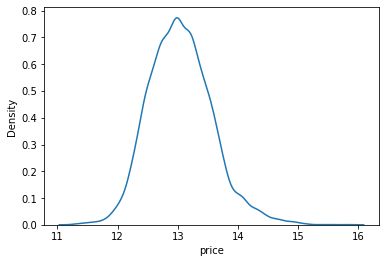

In [9]:
sns.kdeplot(train['price'])
plt.show()

price와 grade의 관계를 boxplot 형태로 시각화시켜서 확인해보았다.   
   
grade는 집의 등급을 매겨놓은 것이라고 한다.   
집의 등급이 높을 수록 가격도 비싸질 것!!  

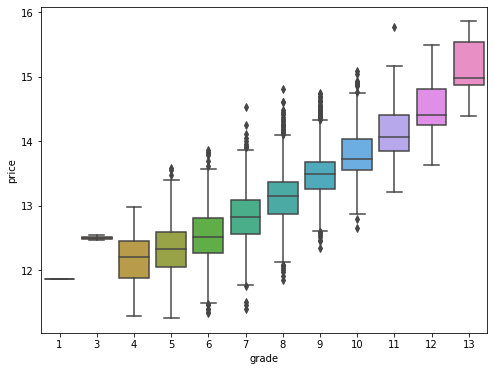

In [10]:
data = pd.concat([train['price'], train['grade']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data=data)

눈에 띄는 부분이 조금 보인다.   
   
grade가 3인 부분이 상대적으로 높아보인다..   
그리고 grade가 11인 곳에서는 점 하나가 상대적으로 높게 있다.   
   
이 두가지를 이상치로 판단하고 데이터에서 빼준다.

In [11]:
train.loc[(train['price'] > 12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [12]:
train.loc[(train['price'] > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [13]:
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 2775]

그 다음으로는 price와 sqft_living의 관계를 확인해본다.   
sqft_living은 주거공간의 평방 피트, 주거공간 면적에 대한 데이터이다.   
마찬가지로 주거공간 면적도 가격이 높아질수록 넓어질것이다...

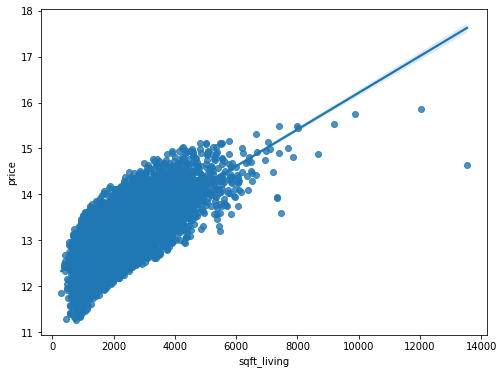

In [14]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

시각화한걸 확인해 봤더니 우측에 sqft_living 값이 12000이 넘어가는 두 점이 보인다.   
특히 14000에 근접한 점은 price가 너무 낮아보인다.   
   
이 둘을 이상치로 판단해서 제거해준다.

In [15]:
train.loc[train['sqft_living'] > 12000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,20141013,15.856731,6,8.0,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8912,8912,20140505,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [16]:
train = train.loc[train['id'] != 5108]
train = train.loc[train['id'] != 8912]

데이터 확인은 여기까지!   
   
이제 train과 test 데이터에서 id 컬럼은 필요없으니까 제거해준다.

In [17]:
del train['id']
del test['id']

그리고 타겟데이터!
price 컬럼을 y에 넣어주고, train 데이터에선 빼준다.

In [18]:
y = train['price']
del train['price']

In [21]:
print(train.columns)
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [22]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15030, dtype: float64

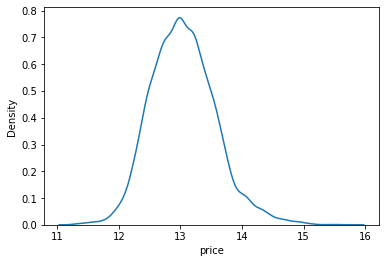

In [23]:
sns.kdeplot(y)
plt.show()

대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE,   
root mean squared error를 구하는 함수를 만들어준다!   
   
y 값이 log로 변환된 값이기 때문에 원래 값으로 되돌려주기 위해 np.expm1() 을 사용한다.

In [24]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

모델 4가지를 가져와서 각 모델이 얻는 점수를 구한다.   
점수를 얻는건 get_scores 함수를 만들어서 진행

In [25]:
random_state=125

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [26]:
# 함수로 만들어줘요 ~<~
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

In [27]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,153322.400195
RandomForestRegressor,147598.822010
LGBMRegressor,128146.699841
XGBRegressor,123313.132416


모델들의 점수를 얻었다!,    
잘나온 2가지 모델을 사용해보려 한다.   
LGBMRegressor 와 XGBRegressor 모델을 사용!

---

모델의 적당한 파라메터 값을 찾기위해 GridSearch를 사용한다.

In [28]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5, verbose=1, n_jobs=5)

    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

In [29]:
param_grid = {
    'n_estimators': [500, 700, 1000, 1200],
    'max_depth': [11, 13, 15],
    'num_leaves': [15, 31],
    'learning_rate': [0.01, 0.02, 0.03, 0.05],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
78,0.05,11,1200,15,-0.025679,0.160248
53,0.03,11,1000,31,-0.025694,0.160292
71,0.03,15,1200,31,-0.025701,0.160316
61,0.03,13,1000,31,-0.025704,0.160326
47,0.02,15,1200,31,-0.025713,0.160352
...,...,...,...,...,...,...
18,0.01,15,700,15,-0.029479,0.171696
2,0.01,11,700,15,-0.029482,0.171703
0,0.01,11,500,15,-0.031781,0.178273
8,0.01,13,500,15,-0.031783,0.178277


하이퍼 파라메터 값들을 얻었고, 이걸 사용해서 모델을 학습시키고 예측한다.

In [31]:
model1 = LGBMRegressor(learning_rate=0.05, max_depth=11, n_estimators=1200, num_leaves=15, random_state=random_state)

In [32]:
model2 = XGBRegressor(learning_rate=0.02, max_depth=6, n_estimators=5000, random_state=random_state)

모델 학습시키고 예측값을 얻는 fit_prediction 함수,   
sample_submission.csv 파일을 불러와서 예측한 값을 넣고 새로운 파일로 저장하는 save_submission 함수,

In [33]:
def fit_prediction(model, train, y, test):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    return prediction
    
def save_submission(prediction, model_name, rmsle=None):
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

LGBM과 XGB의 예측값 결과를 앙상블하고, 그 결과를 사용해서 save_submission 함수로 저장.   

In [34]:
prediction1 = fit_prediction(model1, train, y, test)
prediction2 = fit_prediction(model2, train, y ,test)

ens = prediction1 * 0.5 + prediction2 * 0.5
save_submission(ens, 'enstesteee')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_enstesteee_RMSLE_None.csv saved!


제출할 데이터 완성!

### 캐글에 제출해보기

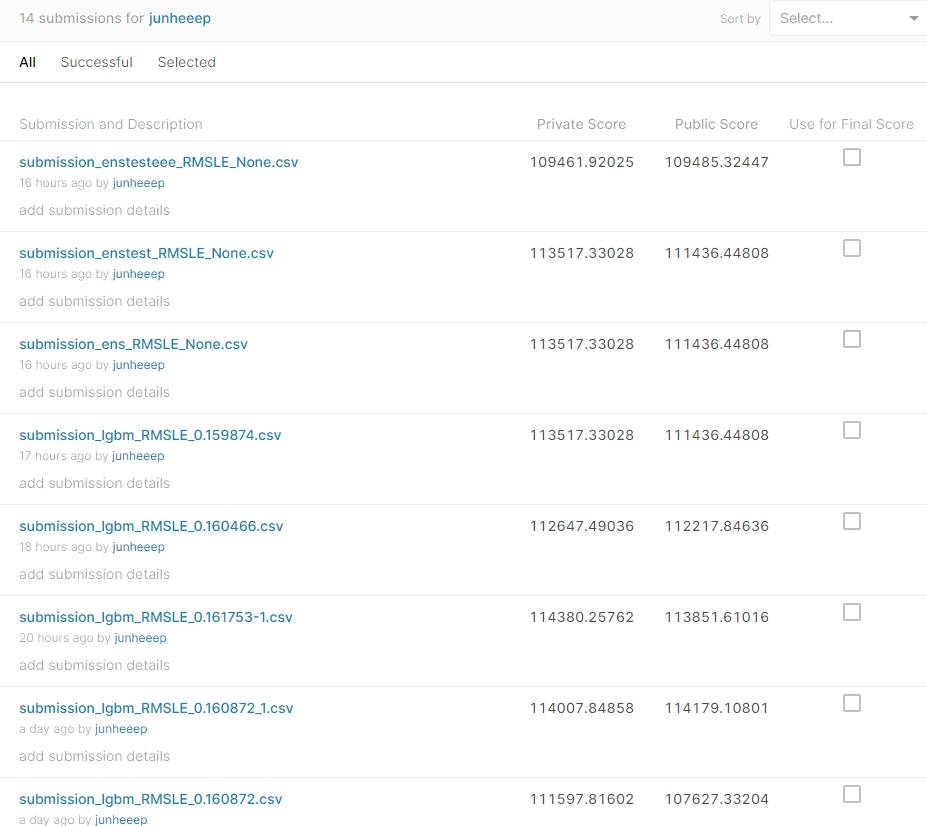

## 회고

+ 초반엔 캐글에 제출했을때 나오는 점수를 11만점 밑으로 맞추는건줄 알고 있었다.   
  그런데 점수가 Private이랑 Public 두가지가 있었다...   
  제출했을때 나오는 점수는 Public만 보여주는거였다.   
  준서님이 안알려주셨으면 모르고 그대로 프로젝트 제출했을지도.  
ㅤ
        
+ 처음엔 하이퍼파라메터 튜닝만 계속해서 붙잡고 있었다.   
  그렇게 하니까 Public score는 11만점 밑으로 내려가는 경우가 있었는데,    
  Private score는 내려갈 기미를 안보여주더라.   
  그래서 다른 방법을 찾아서 진행했다.   
  데이터 전처리에서 데이터 값들을 시각화해보면서 이상치처럼 보이는 데이터를 조금 없애줬다.   
  그리고 ensenble 기법을 사용해봤다.   
  get_scores 함수로 RMSE 점수를 얻은 결과를 보고 잘나온 모델 2가지, LGBM과 XGB 모델을 사용했고,   
  두 모델을 학습시켜서 얻은 예측값을 평균을 내서 사용했다.   
  그 결과를 캐글에 제출해보니 Private score  109461.920215로 루브릭 조건인 11만점 밑을 만족했다!.   
ㅤㅤ
+ GridSearch 너무 오래 걸린다...

### 참고자료

https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12